# Session 15: Image classification with Convolutional NNs

------------------------------------------------------
*Introduction to Data Science & Machine Learning*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

Goals for today:
    - Train an MNIST image classifier based on CNNs
   


This is a personal wrap-up of all the material provided by [Google's Deep Learning course on Udacity](https://www.udacity.com/course/deep-learning--ud730), so all credit goes to them. 

# On convolutional NNs

- Check out the [following slides](http://www.ucsp.edu.pe/ciet/mlss16/file/shlens.pdf)

- The following [paper](https://arxiv.org/pdf/1603.07285v1.pdf) is very nice to understand the arithmetic of convolution operations in 2D

- Check out the following video for a quick introduction to CNNs

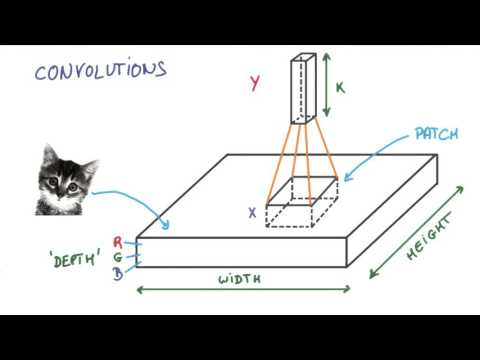

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('jajksuQW4mc') 

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


In [2]:
# Lets check what version of tensorflow we have installed. The provided scripts should run with tf 1.0 and above

print(tf.__version__)

1.3.0


## Loading MNIST database

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
mnist = fetch_mldata('MNIST original')

/Users/olmos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
images = mnist.data.astype(np.float32)
labels = mnist.target

train_dataset,test_dataset,train_labels,test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

train_dataset,valid_dataset,train_labels,valid_labels = train_test_split(train_dataset, train_labels, test_size=0.33, random_state=42)

# Separate a smaller data set for training (20000 images) 
N = 20000

train_dataset = train_dataset[:N,:]
train_labels = train_labels[:N]

### Reformat labels as 1-hot encodings and images into tensors

**Take care! Input image set is now a 4-dimensional tensor! num_images $\times$ image_width $\times$ image_height $\times$ num_channels**

For gray-scale MNIST images, the number of imput channels is one

In [6]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (20000, 28, 28, 1) (20000, 10)
Validation set (15477, 28, 28, 1) (15477, 10)
Test set (23100, 28, 28, 1) (23100, 10)


In [7]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])



Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive to train computationally, so we'll limit its depth and number of fully connected nodes.


## Lets train our first CNN

Two 5x5 convolutional layers with stride 2 and Relu non-linear layers, followed by a fully connected year with soft-max.

<img src="CNN1.png">

The number of parameters of the network is:

- First convolutional Layer: 1 x 16 x 5 x 5 = 400 parameters (+16 of bias)
- Second convolutional Layer: 16 x 16 x 5 x 5 = 6400 parameters (+16 of bias)
- Fully Connected Layer: 224 x 64 = 14336 parameters (+64 of bias)
- Last fully connected layer: 640 parameters (+10 of bias)

** Total: 21882 parameters **

The following code implements the above structure step by step. 

In [10]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden = 64

graphCC = tf.Graph()

with graphCC.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) ##Stride =2 !!
    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases   
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss) 
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))    

In [12]:
num_steps = 1001

with tf.Session(graph=graphCC) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
        
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 33.329277
Minibatch accuracy: 7.0%
Validation accuracy: 22.8%
Minibatch loss at step 100: 0.458786
Minibatch accuracy: 85.9%
Validation accuracy: 90.0%
Minibatch loss at step 200: 0.136763
Minibatch accuracy: 96.1%
Validation accuracy: 93.7%
Minibatch loss at step 300: 0.104762
Minibatch accuracy: 95.3%
Validation accuracy: 94.7%
Minibatch loss at step 400: 0.064228
Minibatch accuracy: 97.7%
Validation accuracy: 95.0%
Minibatch loss at step 500: 0.032896
Minibatch accuracy: 98.4%
Validation accuracy: 94.9%
Minibatch loss at step 600: 0.032589
Minibatch accuracy: 98.4%
Validation accuracy: 95.0%
Minibatch loss at step 700: 0.031264
Minibatch accuracy: 98.4%
Validation accuracy: 95.9%
Minibatch loss at step 800: 0.050192
Minibatch accuracy: 99.2%
Validation accuracy: 95.7%
Minibatch loss at step 900: 0.112647
Minibatch accuracy: 97.7%
Validation accuracy: 95.5%
Minibatch loss at step 1000: 0.053108
Minibatch accuracy: 99.2%
Validation accuracy: 96.2%

## A more complicated CNN: Le-Net 5

The goal is to implement the following network

<img src="CNN2.png">

The number of parameters of the network is:

- First convolutional Layer: 1 x 16 x 5 x 5 = 400 parameters (+16 of bias)
- Second convolutional Layer: 16 x 64 x 5 x 5 = 25600 parameters (+64 of bias)
- **Fully Connected Layer:  3136 x 128 = 401408 parameters (+128 of bias)**
- Fully Connected Layer: 128 x 128 = 16384 parameters (+128 of bias)
- Last fully connected layer: 1280 parameters (+10 of bias)

** Total: 445418 parameters **


We will introduce dropout and [max pooling](http://cs231n.github.io/convolutional-networks/#pool) (instead of stride 2 convolution)

In [22]:
batch_size = 128
patch_size = 5
depth = 16
depth_2 = 64
num_hidden = 128
drop_out = 0.5

graph_CC_LeNet5_v2 = tf.Graph()

with graph_CC_LeNet5_v2.as_default():

    global_step = tf.Variable(0)
    
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth_2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))

    #size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2      #VALID PADDING, AVG_POOL=2
    
    size3 = image_size// 4   #SAME PADDING, AVG_POOL=2
    
    layer3_weights = tf.Variable(tf.truncated_normal([size3 * size3 * depth_2, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_hidden], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer5_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))    
  
    # Model.
    
    pad='SAME'
    
    def model_pol_2(data,prob):
        # C1 input 28 x 28
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding=pad)
        bias1 = tf.nn.relu(conv1 + layer1_biases)
        # S2 input 24 x 24
        pool2 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding=pad)
        # C3 input 12 x 12
        conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding=pad)
        bias3 = tf.nn.relu(conv3 + layer2_biases)
        # S4 input 8 x 8
        pool4 = tf.nn.max_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding=pad)
        # F5 input 4 x 4
        shape = pool4.get_shape().as_list()
        reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden5 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        #F6
        drop5=tf.nn.dropout(hidden5,prob)
        hidden6=tf.nn.relu(tf.matmul(hidden5,layer4_weights)+layer4_biases)
        #drop6=tf.nn.dropout(hidden6,prob)
        return tf.matmul(hidden6, layer5_weights) + layer5_biases
  
    # Training computation.
    logits = model_pol_2(tf_train_dataset,drop_out)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss) 
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    # DROP_OUT is only used in TRAINING!!!
    valid_prediction = tf.nn.softmax(model_pol_2(tf_valid_dataset,1.))
    test_prediction = tf.nn.softmax(model_pol_2(tf_test_dataset,1.))



In [23]:
num_steps = 201

with tf.Session(graph=graph_CC_LeNet5_v2) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
        
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 208.704529
Minibatch accuracy: 11.7%
Validation accuracy: 14.5%
Minibatch loss at step 100: 0.272914
Minibatch accuracy: 91.4%
Validation accuracy: 91.2%
Minibatch loss at step 200: 0.165754
Minibatch accuracy: 95.3%
Validation accuracy: 94.5%
Test accuracy: 94.5%
